In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2023 - 2024 NVIDIA CORPORATION & AFFILIATES.
# SPDX-FileCopyrightText: All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
os.environ["OMP_NUM_THREADS"] = "20"  # 设置 OpenMP 线程数
os.environ["MKL_NUM_THREADS"] = "20"  # 设置 MKL 线程数
os.environ["NUMEXPR_NUM_THREADS"] = "20"  # 设置 NumExpr 线程数
os.environ["VECLIB_MAXIMUM_THREADS"] = "20"  # 设置 veclib 最大线程数
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings("ignore")

import hydra
from omegaconf import OmegaConf, DictConfig
import torch
import torch._dynamo
import nvtx
import numpy as np
import netCDF4 as nc
from modulus.distributed import DistributedManager
from modulus.launch.logging import PythonLogger, RankZeroLoggingWrapper
from modulus import Module
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from einops import rearrange
from torch.distributed import gather


from hydra.utils import to_absolute_path
from modulus.utils.generative import deterministic_sampler, stochastic_sampler
from modulus.utils.corrdiff import (
    NetCDFWriter,
    get_time_from_range,
    regression_step,
    diffusion_step,
)


from helpers.generate_helpers import (
    get_dataset_and_sampler,
    save_images,
)
from helpers.train_helpers import set_patch_shape



In [2]:
###
#
def generate_fn():
    img_shape_y, img_shape_x = img_shape
    with nvtx.annotate("generate_fn", color="green"):
        if cfg.generation.sample_res == "full":
            image_lr_patch = image_lr
        else:
            torch.cuda.nvtx.range_push("rearrange")
            image_lr_patch = rearrange(
                image_lr,
                "b c (h1 h) (w1 w) -> (b h1 w1) c h w",
                h1=img_shape_y // patch_shape[0],
                w1=img_shape_x // patch_shape[1],
            )
            torch.cuda.nvtx.range_pop()
        image_lr_patch = image_lr_patch.to(memory_format=torch.channels_last)

        if net_reg:
            with nvtx.annotate("regression_model", color="yellow"):
                image_reg = regression_step(
                    net=net_reg,
                    img_lr=image_lr_patch,
                    latents_shape=(
                        cfg.generation.seed_batch_size,
                        img_out_channels,
                        img_shape[0],
                        img_shape[1],
                    ),
                )
        if net_res:
            if cfg.generation.hr_mean_conditioning:
                mean_hr = image_reg[0:1]
            else:
                mean_hr = None
            with nvtx.annotate("diffusion model", color="purple"):
                image_res = diffusion_step(
                    net=net_res,
                    sampler_fn=sampler_fn,
                    seed_batch_size=cfg.generation.seed_batch_size,
                    img_shape=img_shape,
                    img_out_channels=img_out_channels,
                    rank_batches=rank_batches,
                    img_lr=image_lr_patch.expand(
                        cfg.generation.seed_batch_size, -1, -1, -1
                    ).to(memory_format=torch.channels_last),
                    rank=dist.rank,
                    device=device,
                    # hr_mean=mean_hr,
                )
        if cfg.generation.inference_mode == "regression":
            image_out = image_reg
        elif cfg.generation.inference_mode == "diffusion":
            image_out = image_res
        else:
            image_out = image_reg + image_res

        if cfg.generation.sample_res != "full":
            image_out = rearrange(
                image_out,
                "(b h1 w1) c h w -> b c (h1 h) (w1 w)",
                h1=img_shape_y // patch_shape[0],
                w1=img_shape_x // patch_shape[1],
            )

        # Gather tensors on rank 0
        if dist.world_size > 1:
            if dist.rank == 0:
                gathered_tensors = [
                    torch.zeros_like(
                        image_out, dtype=image_out.dtype, device=image_out.device
                    )
                    for _ in range(dist.world_size)
                ]
            else:
                gathered_tensors = None

            torch.distributed.barrier()
            gather(
                image_out,
                gather_list=gathered_tensors if dist.rank == 0 else None,
                dst=0,
            )

            if dist.rank == 0:
                return torch.cat(gathered_tensors)
            else:
                return None
        else:
            return image_out


# 
###

In [8]:
from omegaconf import OmegaConf
import hydra
from hydra import initialize, compose

## 解析配置文件
with initialize(config_path='conf',version_base= '1.2'):
    mainconf = compose(config_name = 'config_generate_mini.yaml')
    confkey = list(mainconf.keys())
print('============CorrDiff Downscale Conf============')
print(f"Conf list: {confkey}")
for confn in confkey:
    print(f"\nConf Para --> {confn}")
    print(f"<<{mainconf[confn]}>>")
cfg = mainconf

============CorrDiff Downscale Conf============
Conf list: ['dataset', 'sampler', 'generation']

Conf Para --> dataset
<<{'type': 'hrrr_mini', 'data_path': '/home/sprixin/test/zhangmy/hrrr_mini/hrrr_mini_train.nc', 'stats_path': '/home/sprixin/test/zhangmy/hrrr_mini/stats.json', 'output_variables': ['10u', '10v']}>>

Conf Para --> sampler
<<{'type': 'stochastic', 'boundary_pix': 2, 'overlap_pix': 0}>>

Conf Para --> generation
<<{'num_ensembles': 2, 'seed_batch_size': 1, 'inference_mode': 'all', 'patch_size': 448, 'patch_shape_x': 448, 'patch_shape_y': 448, 'overlap_pixels': 0, 'boundary_pixels': 0, 'hr_mean_conditioning': True, 'gridtype': 'sinusoidal', 'N_grid_channels': 4, 'sample_res': 'full', 'times_range': None, 'times': ['2020-02-02T00:00:00'], 'perf': {'force_fp16': False, 'use_torch_compile': False, 'num_writer_workers': 1}, 'io': {'res_ckpt_filename': 'diffusion_checkpoint.mdlus', 'reg_ckpt_filename': 'regression_checkpoint.mdlus', 'output_filename': './'}}>>


In [9]:
###
cfg.generation.io.res_ckpt_filename = '/home/sprixin/test/zhangmy/corrdiff/output_mod/EDMPrecondSR.0.7055104.mdlus'
cfg.generation.io.reg_ckpt_filename = '/home/sprixin/test/zhangmy/corrdiff/output_mod/UNet.0.2000128.mdlus'
cfg.generation.io.output_filename = "/home/sprixin/test/zhangmy/corrdiff/output_mod/corrdiff_output_7055104.nc"
###

In [10]:
"""
Generate random images using the techniques described in the paper
    "Elucidating the Design Space of Diffusion-Based Generative Models".
"""

# Initialize distributed manager
DistributedManager.initialize()
dist = DistributedManager()
device = dist.device

# Initialize logger
logger = PythonLogger("generate")  # General python logger
logger0 = RankZeroLoggingWrapper(logger, dist)
logger.file_logging("generate.log")

# Handle the batch size
seeds = list(np.arange(cfg.generation.num_ensembles))
num_batches = (
                      (len(seeds) - 1) // (cfg.generation.seed_batch_size * dist.world_size) + 1
              ) * dist.world_size
all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
rank_batches = all_batches[dist.rank :: dist.world_size]

In [11]:
# Synchronize
if dist.world_size > 1:
    torch.distributed.barrier()

# Parse the inference input times
if cfg.generation.times_range and cfg.generation.times:
    raise ValueError("Either times_range or times must be provided, but not both")
if cfg.generation.times_range:
    times = get_time_from_range(cfg.generation.times_range)
else:
    times = cfg.generation.times

In [12]:
# Create dataset object
dataset_cfg = OmegaConf.to_container(cfg.dataset)
dataset, sampler = get_dataset_and_sampler(dataset_cfg=dataset_cfg, times=times)
img_shape = dataset.image_shape()
img_out_channels = len(dataset.output_channels())

In [112]:

# Parse the patch shape
if hasattr(cfg.generation, "patch_shape_x"):  # TODO better config handling
    patch_shape_x = cfg.generation.patch_shape_x
else:
    patch_shape_x = None
if hasattr(cfg.generation, "patch_shape_y"):
    patch_shape_y = cfg.generation.patch_shape_y
else:
    patch_shape_y = None
patch_shape = (patch_shape_y, patch_shape_x)
img_shape, patch_shape = set_patch_shape(img_shape, patch_shape)
if patch_shape != img_shape:
    logger0.info("Patch-based training enabled")
else:
    logger0.info("Patch-based training disabled")


[10:42:06 - generate - INFO] Patch-based training disabled


In [113]:
# Parse the inference mode
if cfg.generation.inference_mode == "regression":
    load_net_reg, load_net_res = True, False
elif cfg.generation.inference_mode == "diffusion":
    load_net_reg, load_net_res = False, True
elif cfg.generation.inference_mode == "all":
    load_net_reg, load_net_res = True, True
else:
    raise ValueError(f"Invalid inference mode {cfg.generation.inference_mode}")

# Load diffusion network, move to device, change precision
if load_net_res:
    res_ckpt_filename = cfg.generation.io.res_ckpt_filename
    logger0.info(f'Loading residual network from "{res_ckpt_filename}"...')
    net_res = Module.from_checkpoint(to_absolute_path(res_ckpt_filename))
    net_res = net_res.eval().to(device).to(memory_format=torch.channels_last)
    if cfg.generation.perf.force_fp16:
        net_res.use_fp16 = True
else:
    net_res = None

# load regression network, move to device, change precision
if load_net_reg:
    reg_ckpt_filename = cfg.generation.io.reg_ckpt_filename
    logger0.info(f'Loading network from "{reg_ckpt_filename}"...')
    net_reg = Module.from_checkpoint(to_absolute_path(reg_ckpt_filename))
    net_reg = net_reg.eval().to(device).to(memory_format=torch.channels_last)
    if cfg.generation.perf.force_fp16:
        net_reg.use_fp16 = True
else:
    net_reg = None

[10:42:06 - generate - INFO] Loading residual network from "/home/sprixin/test/zhangmy/corrdiff/output_mod/EDMPrecondSR.0.7055104.mdlus"...
[10:42:11 - generate - INFO] Loading network from "/home/sprixin/test/zhangmy/corrdiff/output_mod/UNet.0.2000128.mdlus"...


In [114]:
# Reset since we are using a different mode.
if cfg.generation.perf.use_torch_compile:
    torch._dynamo.reset()
    # Only compile residual network
    # Overhead of compiling regression network outweights any benefits
    if net_res:
        net_res = torch.compile(net_res, mode="reduce-overhead")

# Partially instantiate the sampler based on the configs
if cfg.sampler.type == "deterministic":
    if cfg.generation.hr_mean_conditioning:
        raise NotImplementedError(
            "High-res mean conditioning is not yet implemented for the deterministic sampler"
        )
    sampler_fn = partial(
        deterministic_sampler,
        num_steps=cfg.sampler.num_steps,
        # num_ensembles=cfg.generation.num_ensembles,
        solver=cfg.sampler.solver,
    )
elif cfg.sampler.type == "stochastic":
    sampler_fn = partial(
        stochastic_sampler,
        img_shape=img_shape[1],
        patch_shape=patch_shape[1],
        boundary_pix=cfg.sampler.boundary_pix,
        overlap_pix=cfg.sampler.overlap_pix,
    )
else:
    raise ValueError(f"Unknown sampling method {cfg.sampling.type}")


In [115]:
# generate images
output_path = getattr(cfg.generation.io, "output_filename", "corrdiff_output.nc")
logger0.info(f"Generating images, saving results to {output_path}...")
batch_size = 1
warmup_steps = min(len(times) - 1, 2)
# Generates model predictions from the input data using the specified
# `generate_fn`, and save the predictions to the provided NetCDF file. It iterates
# through the dataset using a data loader, computes predictions, and saves them along
# with associated metadata.

[10:42:16 - generate - INFO] Generating images, saving results to /home/sprixin/test/zhangmy/corrdiff/output_mod/corrdiff_output_7055104.nc...


In [116]:
if os.path.exists(output_path):os.remove(output_path)
if dist.rank == 0:
    f = nc.Dataset(output_path, "w")
    # add attributes
    f.cfg = str(cfg)

In [117]:
with torch.cuda.profiler.profile():
    with torch.autograd.profiler.emit_nvtx():

        data_loader = torch.utils.data.DataLoader(
            dataset=dataset, sampler=sampler, batch_size=1, pin_memory=True
        )
        time_index = -1
        if dist.rank == 0:
            writer = NetCDFWriter(
                f,
                lat=dataset.latitude(),
                lon=dataset.longitude(),
                input_channels=dataset.input_channels(),
                output_channels=dataset.output_channels(),
            )

            # Initialize threadpool for writers
            writer_executor = ThreadPoolExecutor(
                max_workers=cfg.generation.perf.num_writer_workers
            )
            writer_threads = []

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        # times = dataset.time()
        dttimes = dataset.time()
        for image_tar, image_lr, index in iter(data_loader):
            time_index += 1
            if dist.rank == 0:
                logger0.info(f"starting index: {time_index}")

            if time_index == warmup_steps:
                start.record()

            # continue
            image_lr = (
                image_lr.to(device=device)
                .to(torch.float32)
                .to(memory_format=torch.channels_last)
            )
            image_tar = image_tar.to(device=device).to(torch.float32)
            image_out = generate_fn()

            if dist.rank == 0:
                batch_size = image_out.shape[0]
                # write out data in a seperate thread so we don't hold up inferencing
                writer_threads.append(
                    writer_executor.submit(
                        save_images,
                        writer,
                        dataset,
                        list(dttimes),
                        image_out.cpu(),
                        image_tar.cpu(),
                        image_lr.cpu(),
                        time_index,
                        ## index[0]
                        sampler[time_index],
                    )
                )
        end.record()
        end.synchronize()
        elapsed_time = start.elapsed_time(end) / 1000.0  # Convert ms to s
        timed_steps = time_index + 1 - warmup_steps
        if dist.rank == 0:
            average_time_per_batch_element = elapsed_time / timed_steps / batch_size
            logger.info(
                f"Total time to run {timed_steps} steps and {batch_size} members = {elapsed_time} s"
            )
            logger.info(
                f"Average time per batch element = {average_time_per_batch_element} s"
            )

        # make sure all the workers are done writing
        if dist.rank == 0:
            for thread in list(writer_threads):
                thread.result()
                writer_threads.remove(thread)
            writer_executor.shutdown()
    if dist.rank == 0:
        f.close()
    logger0.info("Generation Completed.")
    
    
    

[10:42:17 - generate - INFO] starting index: 0
100%|██████████| 2/2 [00:01<00:00,  1.40batch/s]
[10:42:18 - generate - INFO] Total time to run 1 steps and 2 members = 1.4823834228515624 s
[10:42:18 - generate - INFO] Average time per batch element = 0.7411917114257812 s
[10:42:18 - generate - INFO] Generation Completed.


### matplot

In [118]:
img_shape_y, img_shape_x = img_shape
with nvtx.annotate("generate_fn", color="green"):
    if cfg.generation.sample_res == "full":
        image_lr_patch = image_lr
    else:
        torch.cuda.nvtx.range_push("rearrange")
        image_lr_patch = rearrange(
            image_lr,
            "b c (h1 h) (w1 w) -> (b h1 w1) c h w",
            h1=img_shape_y // patch_shape[0],
            w1=img_shape_x // patch_shape[1],
        )
        torch.cuda.nvtx.range_pop()
    image_lr_patch = image_lr_patch.to(memory_format=torch.channels_last)

    if net_reg:
        with nvtx.annotate("regression_model", color="yellow"):
            image_reg = regression_step(
                net=net_reg,
                img_lr=image_lr_patch,
                latents_shape=(
                    cfg.generation.seed_batch_size,
                    img_out_channels,
                    img_shape[0],
                    img_shape[1],
                ),
            )

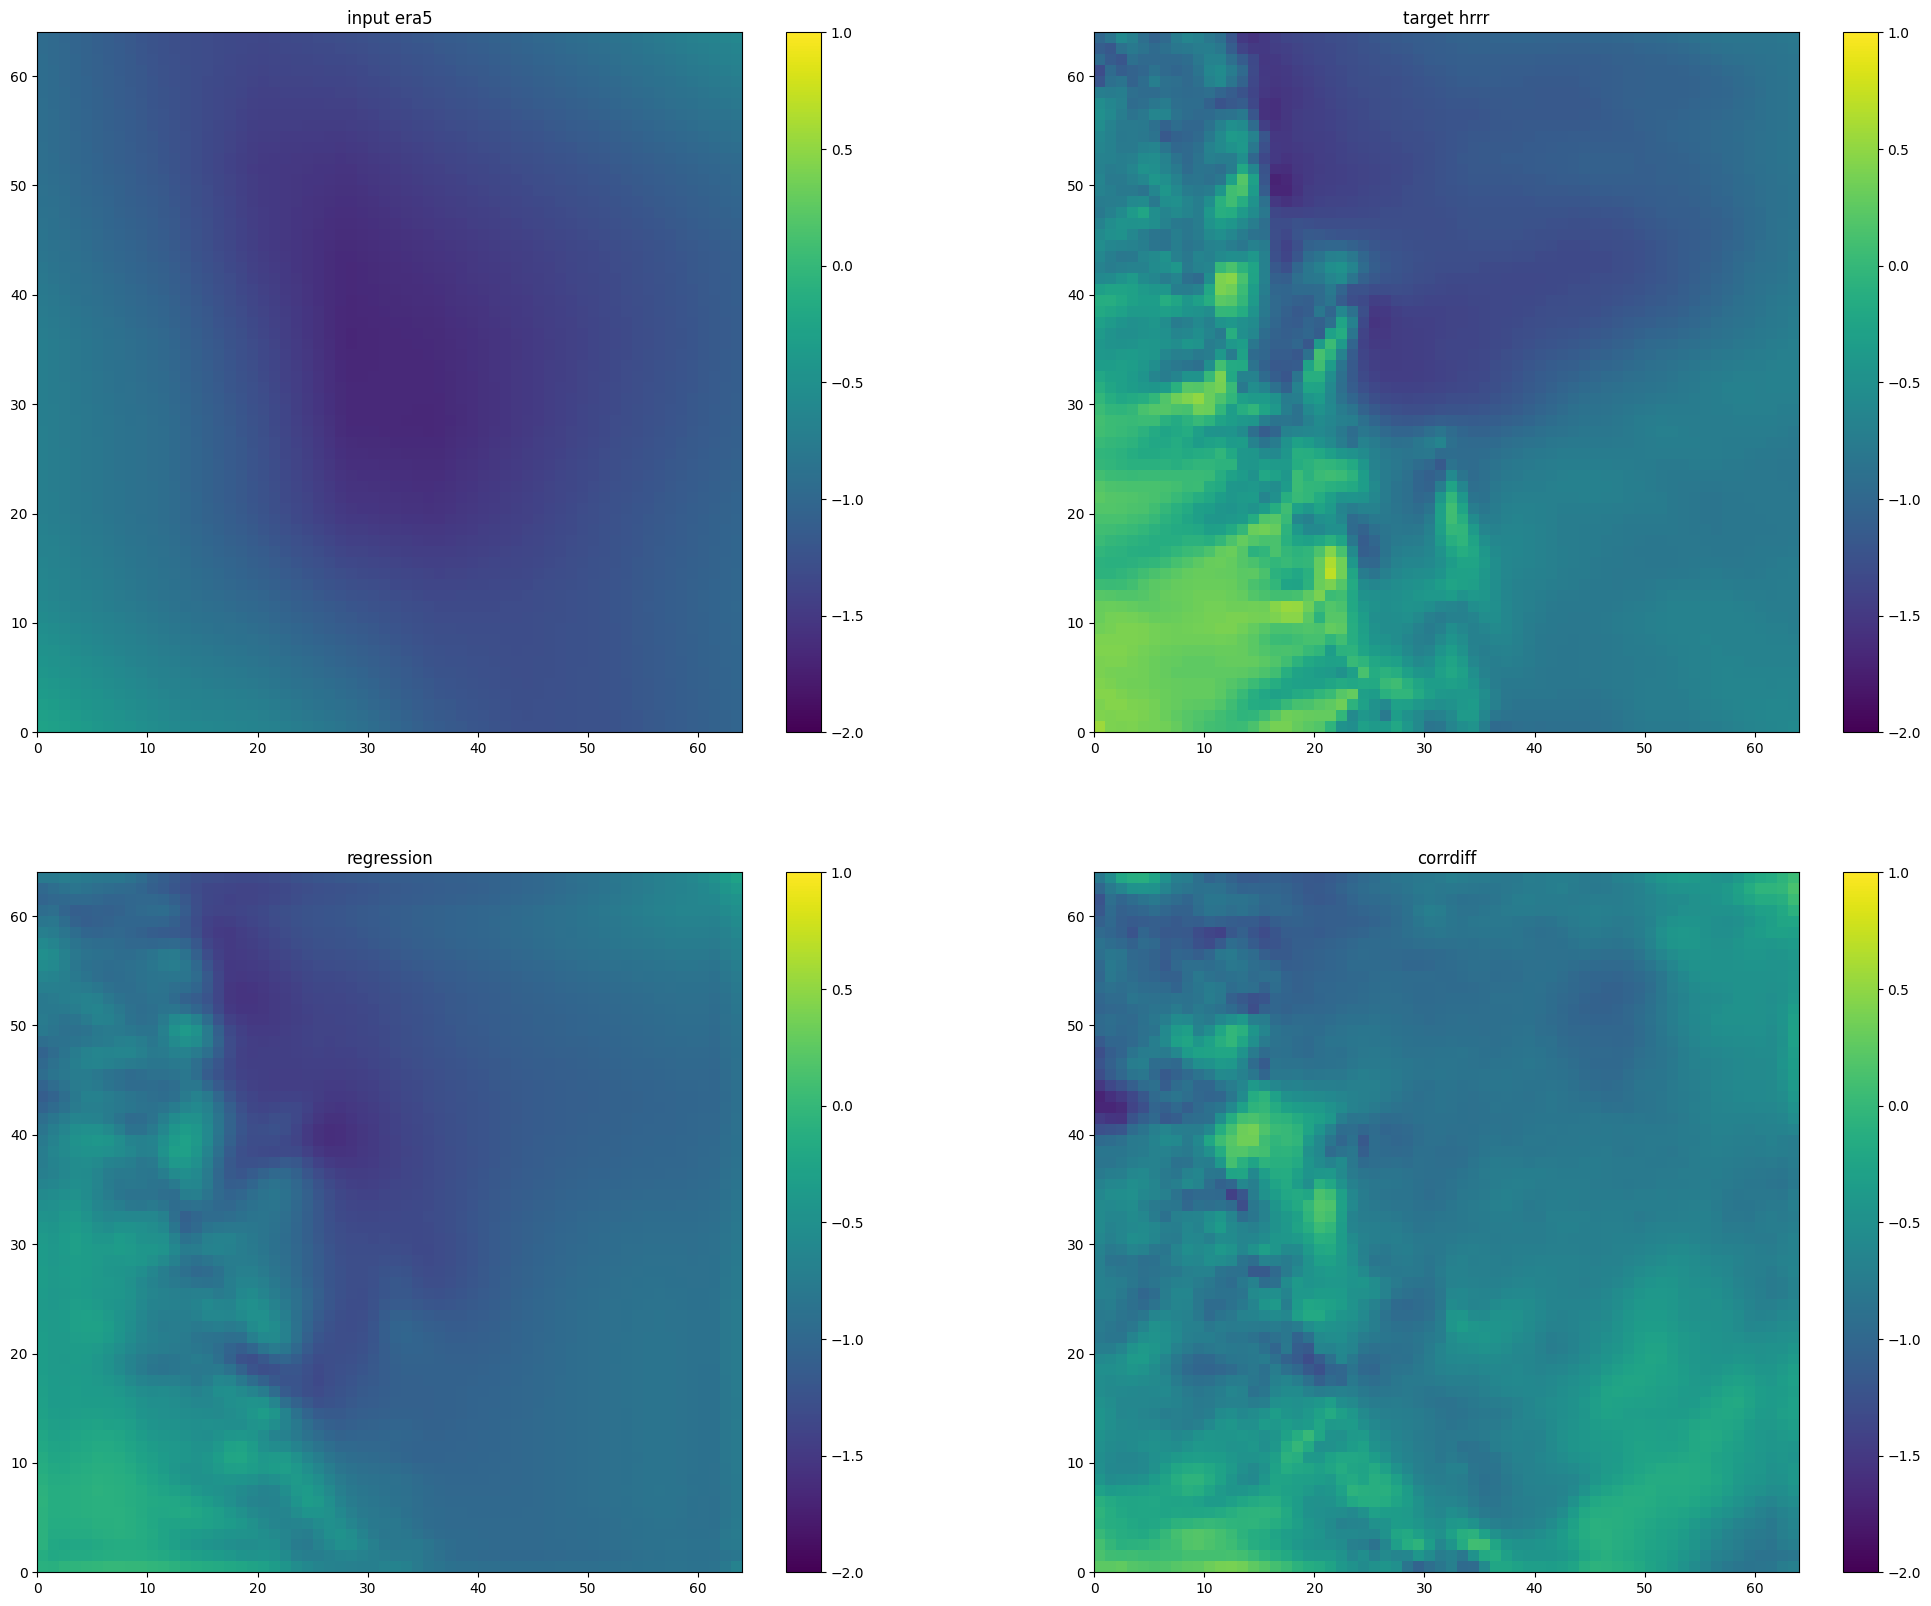

In [119]:
import matplotlib.pyplot as plt


plt.figure(figsize=(25,20))
plt.subplot(2,2,1)
plt.pcolormesh(image_lr.cpu()[0,1,:,:], vmin=-2, vmax=1)
plt.title('input era5')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(image_tar.cpu()[0,1,:,:], vmin=-2, vmax=1)
plt.title('target hrrr')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(image_reg.cpu()[0,1,:,:], vmin=-2, vmax=1)
plt.title('regression')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolormesh(image_out.cpu()[0,1,:,:], vmin=-2, vmax=1)
plt.title('corrdiff')
plt.colorbar()

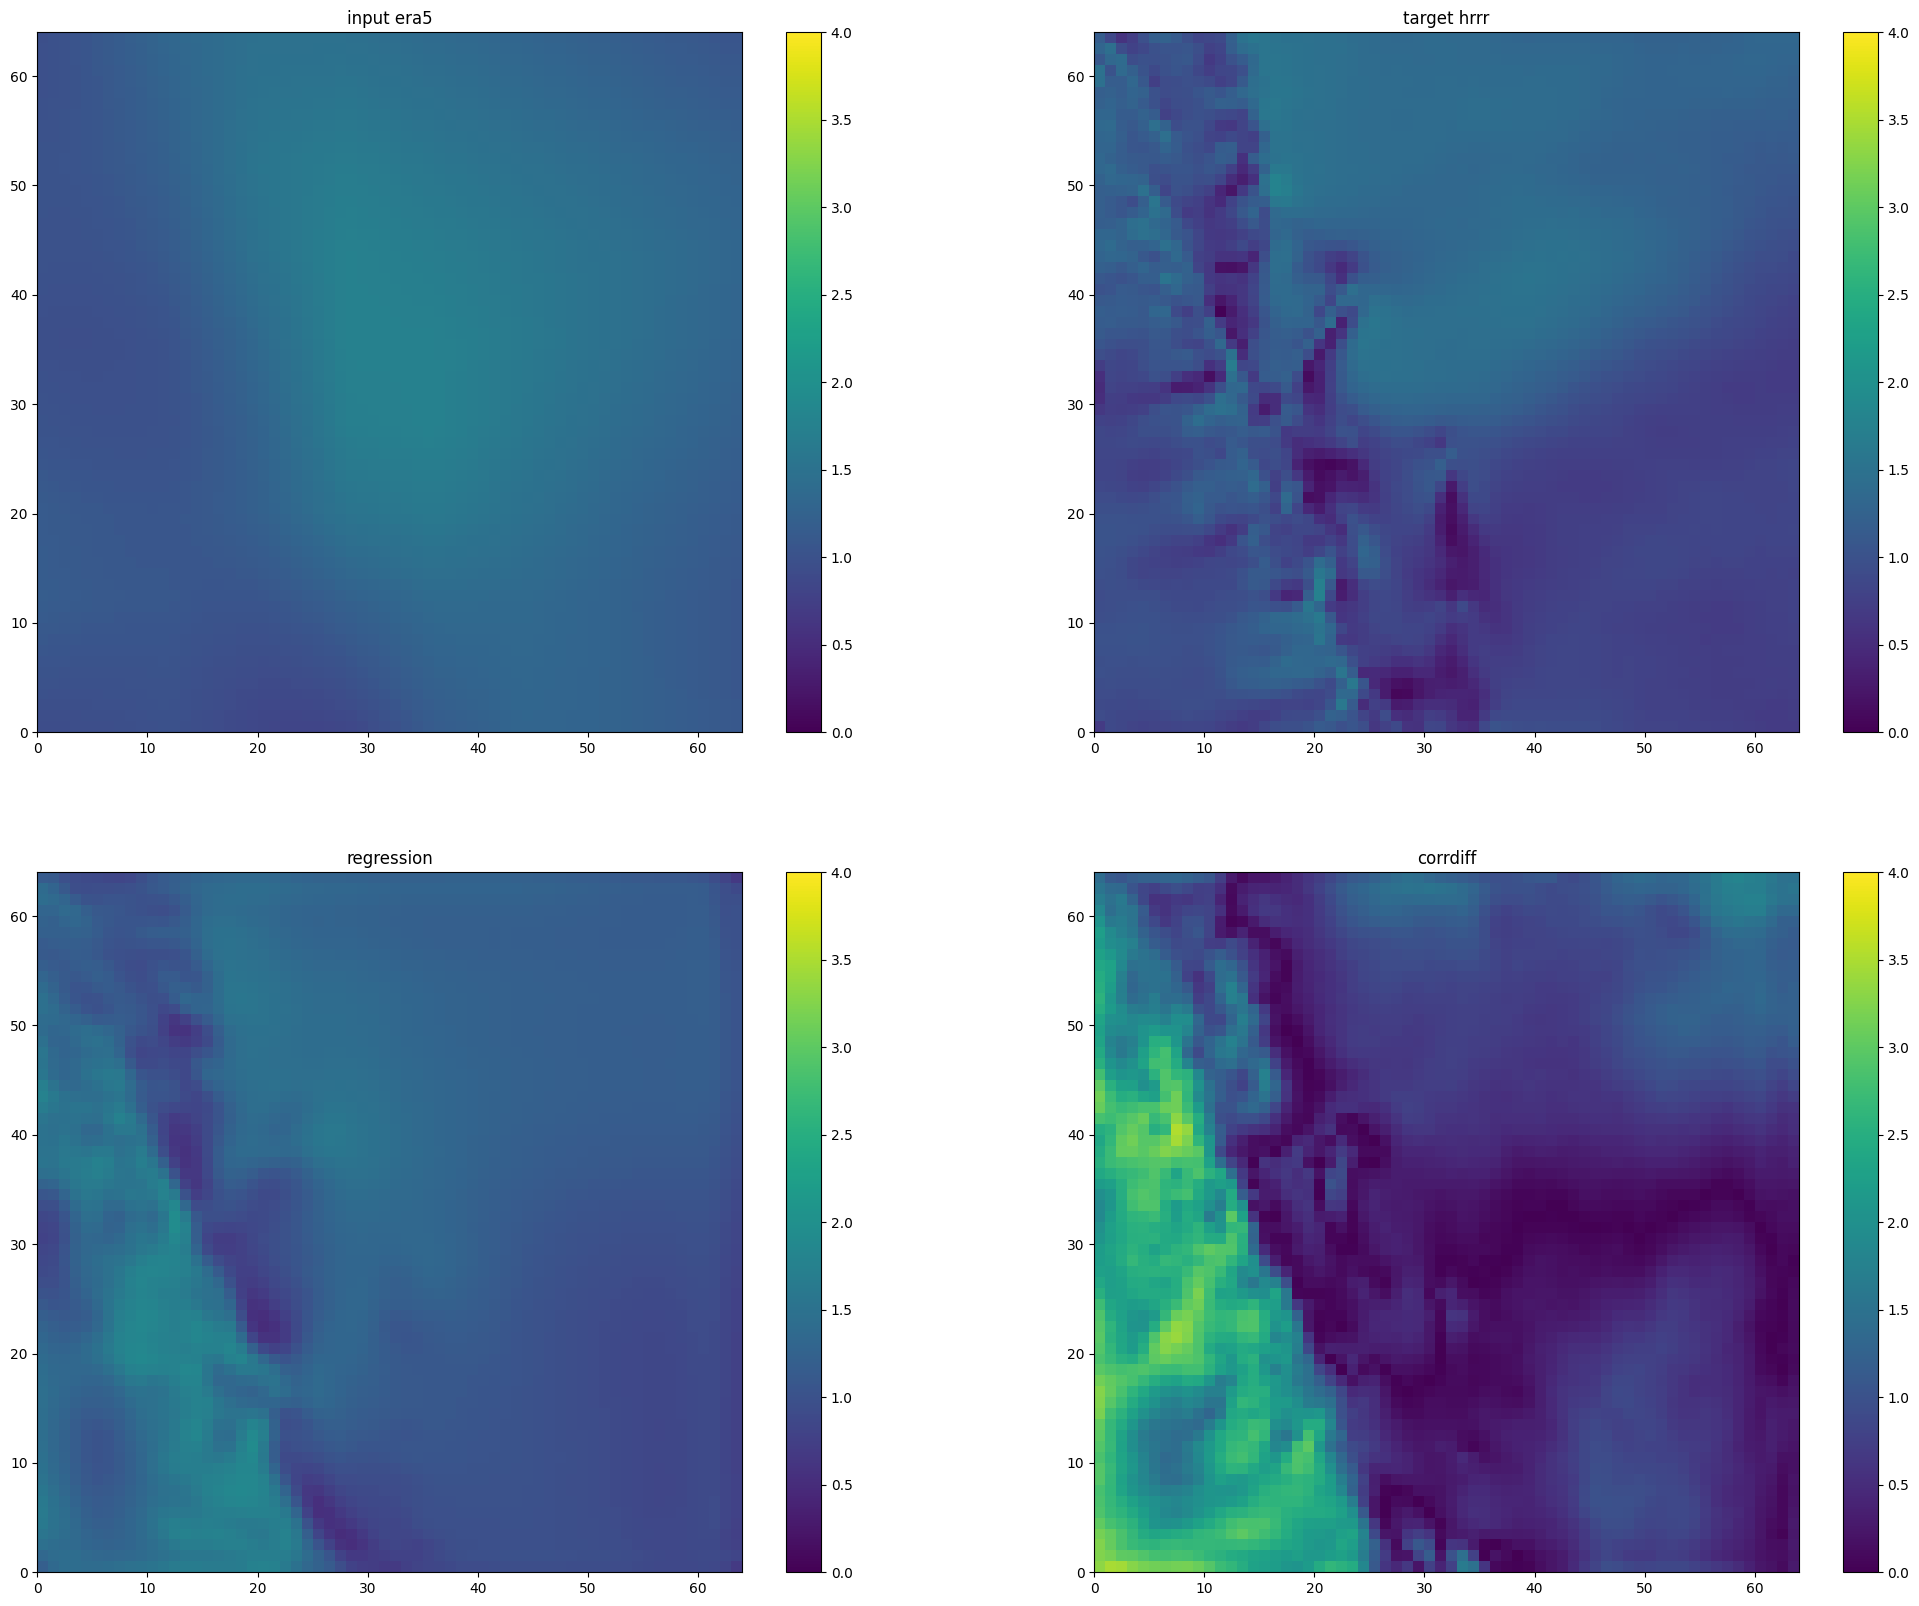

In [120]:
plt.figure(figsize=(25,20))
plt.subplot(2,2,1)
plt.pcolormesh(np.sqrt(image_lr.cpu()[0,0,:,:]**2 + image_lr.cpu()[0,1,:,:]**2), vmin=0, vmax=4)
plt.title('input era5')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolormesh(np.sqrt(image_tar.cpu()[0,0,:,:]**2 + image_tar.cpu()[0,1,:,:]**2), vmin=0, vmax=4)
plt.title('target hrrr')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolormesh(np.sqrt(image_reg.cpu()[0,0,:,:]**2 + image_reg.cpu()[0,1,:,:]**2), vmin=0, vmax=4)
plt.title('regression')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolormesh(np.sqrt(image_out.cpu()[0,0,:,:]**2 + image_out.cpu()[0,0,:,:]**2), vmin=0, vmax=4)
plt.title('corrdiff')
plt.colorbar()

NameError: name 'image_out' is not defined

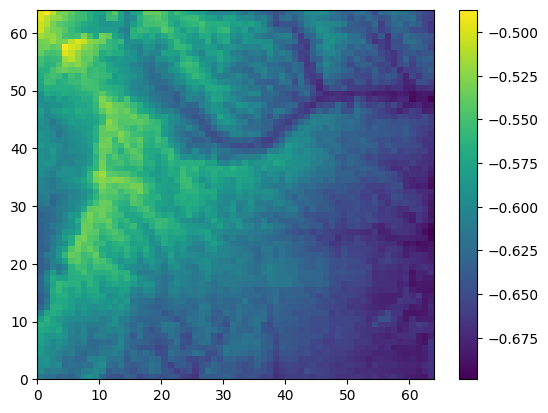

In [100]:
plt.pcolormesh(image_lr_patch.cpu()[0,-2,:,:])
plt.colorbar()

Text(0.5, 1.0, 'corrdiff')

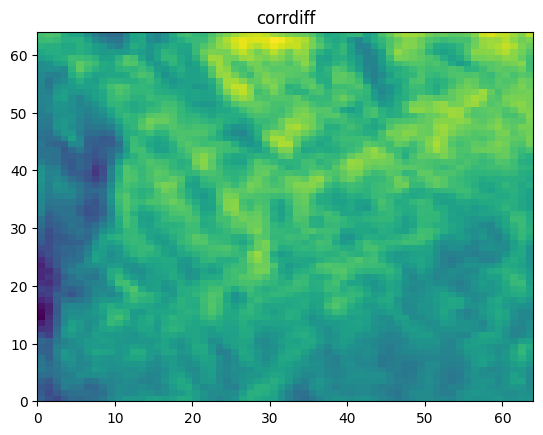

In [101]:
plt.pcolormesh(image_out.cpu()[0,0,:,:])
plt.title('corrdiff')

In [5]:
import zarr as zr
zrpath = '/home/sprixin/test/zhangmy/cwa_dataset/cwa_dataset.zarr'
zr.load(zrpath)

<LazyLoader: XLAT, XLAT_U, XLAT_V, XLONG, XLONG_U, XLONG_V, XTIME, cwb, cwb_center, cwb_pressure, cwb_scale, cwb_valid, cwb_variable, era5, era5_center, era5_pressure, era5_scale, era5_valid, era5_variable, time>

In [6]:
group = zr.open_consolidated(zrpath)

In [7]:
ze = zr.open(zrpath, mode = 'r')

In [8]:
group['era5_variable'][:]

array(['tcwv', 'geopotential_height', 'temperature', 'eastward_wind',
       'northward_wind', 'geopotential_height', 'temperature',
       'eastward_wind', 'northward_wind', 'geopotential_height',
       'temperature', 'eastward_wind', 'northward_wind',
       'geopotential_height', 'temperature', 'eastward_wind',
       'northward_wind', 'temperature_2m', 'eastward_wind_10m',
       'northward_wind_10m'], dtype='<U19')

In [9]:
group['cwb_pressure'][:]

array([nan, nan, nan, nan])

In [10]:
ze.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,20
No. arrays,20
No. groups,0
Arrays,"XLAT, XLAT_U, XLAT_V, XLONG, XLONG_U, XLONG_V, XTIME, cwb, cwb_center, cwb_pressure, cwb_scale, cwb_valid, cwb_variable, era5, era5_center, era5_pressure, era5_scale, era5_valid, era5_variable, time"


In [11]:
zr.tree(ze)

ImportError: No module named 'ipytree': Run `pip install zarr[jupyter]` or `conda install ipytree`to get the required ipytree dependency for displaying the tree widget. If using jupyterlab<3, you also need to run `jupyter labextension install ipytree`

/
 ├── XLAT (450, 450) float32
 ├── XLAT_U (450, 451) float32
 ├── XLAT_V (451, 450) float32
 ├── XLONG (450, 450) float32
 ├── XLONG_U (450, 451) float32
 ├── XLONG_V (451, 450) float32
 ├── XTIME () float32
 ├── cwb (35064, 4, 450, 450) float32
 ├── cwb_center (4,) float32
 ├── cwb_pressure (4,) float64
 ├── cwb_scale (4,) float32
 ├── cwb_valid (35064,) int8
 ├── cwb_variable (4,) <U26
 ├── era5 (35064, 20, 450, 450) float32
 ├── era5_center (20,) float32
 ├── era5_pressure (20,) float64
 ├── era5_scale (20,) float32
 ├── era5_valid (35064, 20) int8
 ├── era5_variable (20,) <U19
 └── time (35064,) int64